### Survey Tutorial

This Tutorial is going to teach you an accessible way to start with the Survey class. You learn about helpful attributes of the Survey class and some useful methods. <br>
At the completion of the Tutorial, you learn to create the Survey class and study common features.<br>
Tutorial reading takes N minutes.

### Content

[SEG-Y format](#SEG-Y-format) <br>
[Starting](#Starting) <br>
[Attributes](#Attributes) <br>
[Methods](#Methods) <br>
[Creating Gather](#Creating-Gather) <br>
[Conclusion](#Conclusion) <br>

In [1]:
import sys # delete after finish
sys.path.append('..') # delete after finish

from seismicpro import Survey
import matplotlib.pyplot as plt

### SEG-Y format

Before we start to talk about the Survey class, let's a few words about the SEG-Y format.

SEG-Y format is the primary data format for collecting seismic data. <br>
This format was assigned by the convention of the Society of Exploration Geophysicist Foundation. <br>
The latest version of the SEG-Y format is 'revision 2' enacted in 2017. <br>
There are main part:<br>
- the File Header with information about the seismic survey.
- the Trace Headers with information about each trace.
- the Data Trace.

Scheme of SEG-Y format of revision 2 <br>
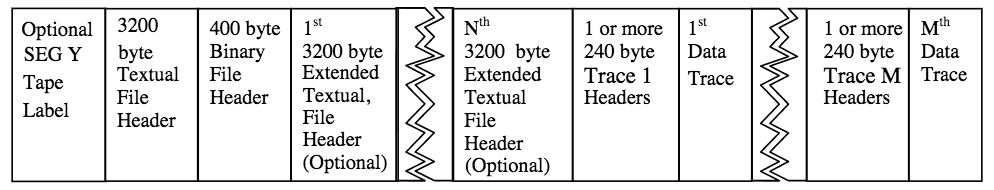

SEG-Y files contain all information about the seismic survey. Therefore, the SEG-Y file takes much space and hard to iterate over the data.

The Survey class is a concise image of the SEG-Y file. Survey keeps only a file info and trace headers and has some methods for interacting with headers.<br>
Methods help with data trace exctraction presented too.

Survey class data structure cheap for computing and data extraction. <br>
Also, it makes easy to pick up needful data for the machine learning tasks. <br>

### Starting
We will consider the creation of a Survey class example and go into its structure.

Survey keeps the trace headers as `pandas.Dataframe` named `headers`.<br>
For creation, we need to specify the path to SEG-Y files and the headers we want to use.<br> 
Only specified headers will be loading from SEG-Y files. /// It makes a Survey class a little again.

We need to specify headers in `header_index` that we want to use for the subsequent trace data extraction. <br>

Other interesting headers we could specify in `header_cols`.

You could check the full list of trace headers [here](https://segyio.readthedocs.io/en/latest/segyio.html#constants) in the `Trace headers keys` block. <br>

In [2]:
sgy_path = './data/small_survey.sgy'
survey = Survey(sgy_path, header_index='FieldRecord', header_cols='offset')

Let's see information about the created class object <br>

In [3]:
survey.info()


Survey path:               ./data/small_survey.sgy
Survey name:               small_survey
Survey size:               0.098 GB
Number of traces:          8640
Traces length:             3000 samples
Sample rate:               2.0 ms
Offsets range:             [79 m, 4984 m]

Index name(s):             FieldRecord
Number of unique indices:  5



We see the main information about the newly created `Survey`. <br>
'small_survey' SEG-Y file locate at the `Survey path` takes 98 Mb space on the disk and contains 8640 traces. Each trace has 3000 samples which were being collected with 2 ms time interval. <br>
All of the 8640 traces have offset ranges from 79 to 4984 meters.

Traces in `Survey` indexed by `FieldRecord`. 8640 traces have only 5 unique 'FieldRecord' trace header values. /// чё там про 4 существительных в ряд говорили?

/// убрать в gather ? <br>
Finally, a few words about the relation of `header_index` and data extraction. <br>
We realize loading the trace data with `Gather` object. The Gather takes trace data by indicated `header_index` value only.<br>
Therefore, `header_index` should contain the headers based on the tasks. <br>
Herein before we create the Survey with `header_index=header_index='FieldRecord'`, and we could create shot gather.

There most useful `header_index` define by task.

In [20]:
%%html
# нужно для корретного расположения таблицы по левому краю. убрать при заврешении
<style>
table {float:left}
</style>

| Common gather | header_index |
| :- | -: |
| Common-shot gather | `FieldRecord` |
| Common-midpoint gather | `CDP` |
| Common-offset section | `offset` |
| Common-receiver gather | `[GroupX, GroupY]` |

We could specify `header_index` by the list of headers. /// надо ли вообще это говорить?

### Attributes

Let's discuss the most useful attributes of the Survey class.

<b>`headers`</b> - `pandas.Dataframe` containing the trace headers we explicitly specified when creating the `Survey`. <br>

In [5]:
survey.headers

,offset,TRACE_SEQUENCE_FILE
FieldRecord,,
111916,127,5185
111916,3304,6344
111916,3303,6343
111916,3301,6342
111916,3301,6341
...,...,...
111920,2310,4027
111920,2308,4026
111920,2308,4025


`headers` Dataframe indexed by `FieldRecord`. `offset` values represented by a column.

`TRACE_SEQUENCE_FILE` added to `headers` automatically when Survey is created and contains the unique index of each trace.

<b>`samples`</b> - array of times when the trace record is done, ms

In [6]:
survey.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 5.994e+03, 5.996e+03,
       5.998e+03], dtype=float32)

<b>`sample_rate` </b> - sample interval for each trace, ms

In [7]:
survey.sample_rate

2.0

<b>`samples_length` </b> - number of records for each trace. <br>
Survey class needs that all traces in the SEG-Y file have the same sample_length.

In [8]:
survey.samples_length

3000

We learned about the main attributes of the Survey class.

### Methods

#### <i>filter </i>

`filter` is used to selecting the required traces using the header values of these traces.

`filter` expects a condition given as function (example: lambda function) and `headers`' name by which filtering is done. <br>
For example, we want to select traces with `offset` less than 1500 meters.

In [9]:
filtered_survey = survey.filter(cond=lambda x: x < 1500, cols='offset')
filtered_survey.info()


Survey path:               ./data/small_survey.sgy
Survey name:               small_survey
Survey size:               0.098 GB
Number of traces:          1218
Traces length:             3000 samples
Sample rate:               2.0 ms
Offsets range:             [79 m, 1492 m]

Index name(s):             FieldRecord
Number of unique indices:  5



Now we can see that `Offsets range` does not exceed 1500 m

#### <i>apply </i>

apply a function to `headers` values. /// inspired with numpy and pandas doc style

`Survey.apply` expect a function (example: lambda function) and `headers` name to whose values this function is applied. <br>
For example, we want to increase `offset` by a factor of two. <br>
Since we don't want to overwrite `offset` information, we put the increased values in the new column `offset_x2` using `res_cols` argument.

In [10]:
applied_survey = survey.apply(func=lambda x: x * 2, cols='offset', res_cols='offset_x2')
applied_survey.headers

,offset,TRACE_SEQUENCE_FILE,offset_x2
FieldRecord,,,
111916,127,5185,254
111916,3304,6344,6608
111916,3303,6343,6606
111916,3301,6342,6602
111916,3301,6341,6602
...,...,...,...
111920,2310,4027,4620
111920,2308,4026,4616
111920,2308,4025,4616


Now `headers` contains new column with doubled offsets.<br>

Sometimes in our work we received SEG-Y files with negative `offset`. <br>
There are a easy way to make offset only positive is <br>
`survey = survey.apply(func=lambda x: abs(x), cols='offset', res_cols='positive_offset')`

#### <i>collect_stats </i>

`collect_stats` is used to calculate the traces statistics and save this information to `Survey`.

In [11]:
survey.collect_stats()

Calculating statistics for survey small_survey:   0%|          | 0/8640 [00:00<?, ?it/s]

Another way to calculate statistics is to create `Survey` with flag `collect_stats=True` <br>
For example <br>

`survey_with_stats = Survey(sgy_path, header_index='FieldRecord', header_cols='offset', collect_stats=True)`


In [12]:
survey.info()


Survey path:               ./data/small_survey.sgy
Survey name:               small_survey
Survey size:               0.098 GB
Number of traces:          8640
Traces length:             3000 samples
Sample rate:               2.0 ms
Offsets range:             [79 m, 4984 m]

Index name(s):             FieldRecord
Number of unique indices:  5

Survey statistics:
Number of dead traces:     13
Trace limits:              0:3000:1 samples
mean | std:                      0.00 | 0.54      
 min | max:                   -197.41 | 196.99    
 q01 | q99:                     -1.62 | 1.62      



Now `survey.info()` shows calculated statistics in extra block.

Most traces statistics add to `Survey`'s attributes and available for the direct access. Such as `mean` `std` `min` `max`. <br>
Calculated statistics is very useful for normalizing data in machine learning tasks. <br> 

Quantiles are not written to the Survey's attributes and accessible with `get_quantile()` method.

Also, `Survey` can calculate statistics for the selected part of the traces. <br>
We need to indicate `stats_limits` in ms when the `Survey` is creating.

In [15]:
survey_with_limits = Survey(sgy_path, header_index='FieldRecord', header_cols='offset', collect_stats=True, stats_limits=(0, 1000))
# survey.set_limits(limits=(0,1000))  создание нового сюрвея нужно, чтобы gather в блоке creating gather выбирал все трассы без лимитов
# survey.collect_stats()
survey_with_limits.info()

Calculating statistics for survey small_survey:   0%|          | 0/8640 [00:00<?, ?it/s]


Survey path:               ./data/small_survey.sgy
Survey name:               small_survey
Survey size:               0.098 GB
Number of traces:          8640
Traces length:             1000 samples
Sample rate:               2.0 ms
Offsets range:             [79 m, 4984 m]

Index name(s):             FieldRecord
Number of unique indices:  5

Survey statistics:
Number of dead traces:     13
Trace limits:              0:1000:1 samples
mean | std:                      0.00 | 0.49      
 min | max:                    -23.04 | 27.05     
 q01 | q99:                     -1.40 | 1.41      



Survey statistics are different in this case because only part of traces (from 0 to 1000 ms) are used for statistics calculation. <br>

We could collect statistic with limits when Survey is creating with `stat_limitis`:<br>
`survey_with_limits = Survey(sgy_path, header_index='FieldRecord', header_cols='offset', collect_stats=True, stats_limits=(0, 1000))`

#### Creating Gather

Survey doesn't load traces from SEG-Y files. <br>
To get the trace data you need to create `Gather` object using the `sample_gather` or `get_gather` methods.

`sample_gather` randomly selects an index value from `header_index` and returns all traces with this index as `Gather` object. <br>

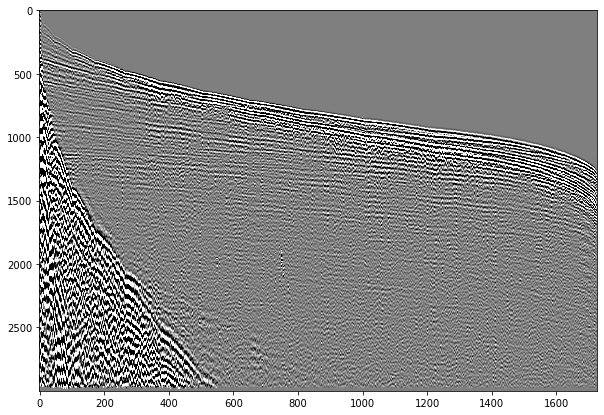

In [16]:
gather = survey.sample_gather().sort(by='offset') # delete sort after finish
gather.plot()

More about how to smart sample trace and more about `Gather` object in [this tutorial].

### Conclusion

I glad that you read this. It's mean that you read Survey tutorial at the end.

I hope tutorial is simple to understand and useful for you. <br>
More information and full documentation you could find [here]. <br>

If you still have any question you could free contact with our team by [...].


To return to tutorials list [click here]